In [1]:
#Imports
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
#Projekt Root, Pfade, Daten laden
# Notebook läuft in /rookie_invest_ML/notebooks, daher ist der Projektroot ein Ordner höher
PROJECT_ROOT = Path(os.getcwd()).parent
print("CWD:", Path(os.getcwd()))
print("PROJECT_ROOT:", PROJECT_ROOT)

DATA_PATH = PROJECT_ROOT / "data/model_input/f2_f3_features_with_f1_label.csv"
if not DATA_PATH.exists():
    raise FileNotFoundError(f"CSV nicht gefunden: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)

print("Loaded:", DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))


CWD: /Users/sheyla/Desktop/rookie_invest_ML/notebooks
PROJECT_ROOT: /Users/sheyla/Desktop/rookie_invest_ML
Loaded: /Users/sheyla/Desktop/rookie_invest_ML/data/model_input/f2_f3_features_with_f1_label.csv
Shape: (488, 28)


,series,year,driver_name,driver_code,team_name,n_races,total_points,avg_points,avg_finish,best_finish,...,top10_rate,total_laps,avg_kph,finish_std,points_std,dnf_count,dnf_rate,avg_best_lap_s,first_f1_year,f1_entry
0,F2,2017,A Albon,ALB,ART Grand Prix,10,67.0,6.7,7.7,2,...,0.9,245.0,177.7660,4.498148,6.429965,0.0,0.0,97.6208,2005.0,False
1,F2,2017,R Binder,BIN,Rapax,1,0.0,0.0,17.0,17,...,0.0,28.0,169.5800,NaN,NaN,0.0,0.0,89.0320,NaN,False
2,F2,2017,R Boschung,BOS,Campos Racing,10,2.0,0.2,16.2,9,...,0.1,195.0,174.4635,3.457681,0.632456,5.0,0.5,98.3791,NaN,False


In [3]:
#Sanity Checks: Spalten und Label prüfen
required = ["year", "f1_entry"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Fehlende Spalten: {missing}")

print("Target distribution (f1_entry):")
print(df["f1_entry"].value_counts(dropna=False))

unique_vals = sorted(df["f1_entry"].dropna().unique().tolist())
print("Unique target values:", unique_vals)
if not set(unique_vals).issubset({0, 1}):
    raise ValueError(f"f1_entry ist nicht binär 0/1. Werte: {unique_vals}")


Target distribution (f1_entry):
f1_entry
False    456
True      32
Name: count, dtype: int64
Unique target values: [False, True]


In [4]:
#Zeitbasierter Split
TRAIN_END_YEAR = 2021
TEST_START_YEAR = 2022
TEST_END_YEAR = 2023

train_df = df[df["year"] <= TRAIN_END_YEAR].copy()
test_df = df[(df["year"] >= TEST_START_YEAR) & (df["year"] <= TEST_END_YEAR)].copy()

print("Train rows:", len(train_df), "Years:", train_df["year"].min(), "to", train_df["year"].max())
print("Test rows:", len(test_df), "Years:", test_df["year"].min(), "to", test_df["year"].max())

if len(train_df) == 0 or len(test_df) == 0:
    raise ValueError("Train oder Test ist leer. Prüfe die Jahre oder die Daten.")


Train rows: 234 Years: 2017 to 2021
Test rows: 126 Years: 2022 to 2023


In [5]:
#Features bauen und Leakage entfernen
demo_cols = ["driver_name", "driver_code", "series", "year", "team_name"]

# first_f1_year ist Leakage und darf nicht ins Modell
drop_cols = set(demo_cols + ["f1_entry"])
if "first_f1_year" in df.columns:
    drop_cols.add("first_f1_year")

X_train = train_df.drop(columns=list(drop_cols), errors="ignore")
y_train = train_df["f1_entry"].astype(int)

X_test = test_df.drop(columns=list(drop_cols), errors="ignore")
y_test = test_df["f1_entry"].astype(int)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Positive rate train:", round(float(y_train.mean()), 4))
print("Positive rate test:", round(float(y_test.mean()), 4))


X_train shape: (234, 21)
X_test shape: (126, 21)
Positive rate train: 0.1068
Positive rate test: 0.0556


In [6]:
#Preprocessing
categorical_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
numeric_cols = [c for c in X_train.columns if c not in categorical_cols]

print("Numeric cols:", len(numeric_cols))
print("Categorical cols:", len(categorical_cols))

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)


Numeric cols: 21
Categorical cols: 0


In [7]:
#Modell trainieren und evaluieren
logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ))
])

logreg_model.fit(X_train, y_train)

proba_test = logreg_model.predict_proba(X_test)[:, 1]

roc = roc_auc_score(y_test, proba_test)
pr = average_precision_score(y_test, proba_test)

print("ROC AUC:", round(float(roc), 4))
print("PR AUC:", round(float(pr), 4))


ROC AUC: 0.7563
PR AUC: 0.2753


/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/sheyla/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  g

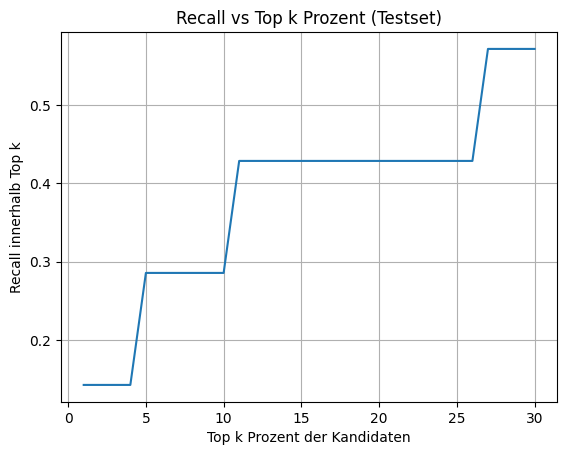

Recall Top 5%: 0.2857
Recall Top 10%: 0.2857
Recall Top 20%: 0.4286


In [8]:
#Top k Recall Kurve
def recall_at_k(y_true: pd.Series, y_score: np.ndarray, k_fraction: float) -> float:
    n = len(y_true)
    k = max(1, int(np.ceil(n * k_fraction)))
    idx = np.argsort(-y_score)[:k]
    found = int(y_true.iloc[idx].sum())
    total_pos = int(y_true.sum())
    return found / max(1, total_pos)

fractions = np.linspace(0.01, 0.30, 30)
recalls = [recall_at_k(y_test, proba_test, f) for f in fractions]

plt.figure()
plt.plot(fractions * 100, recalls)
plt.xlabel("Top k Prozent der Kandidaten")
plt.ylabel("Recall innerhalb Top k")
plt.title("Recall vs Top k Prozent (Testset)")
plt.grid(True)
plt.show()

for f in [0.05, 0.10, 0.20]:
    print(f"Recall Top {int(f*100)}%:", round(recall_at_k(y_test, proba_test, f), 4))


In [9]:
#Ranking Tabelle für die Demo
demo_df = test_df[[c for c in demo_cols if c in test_df.columns]].copy()
demo_df["predicted_probability"] = proba_test
demo_df["actual_label"] = y_test.values

demo_df = demo_df.sort_values("predicted_probability", ascending=False)
display(demo_df.head(20))


,driver_name,driver_code,series,year,team_name,predicted_probability,actual_label
347,O Bearman,BEA,F3,2022,PREMA Racing,0.818594,1
140,F Drugovich,DRU,F2,2022,MP Motorsport,0.791227,0
141,E Fittipaldi,FIT,F2,2022,Charouz Racing System,0.730843,0
387,G Bortoleto,BOR,F3,2023,Trident,0.701703,0
161,L Zendeli,ZEN,F2,2022,Campos Racing,0.701432,0
374,R Stanek,STA,F3,2022,Trident,0.687210,0
154,L Sargeant,SAR,F2,2022,Carlin,0.663653,1
405,J Martí,MAR,F3,2023,Campos Racing,0.648018,0
144,J Hughes,HUG,F2,2022,Van Amersfoort Racing,0.645262,0
153,T Pourchaire,POU,F2,2022,ART Grand Prix,0.619964,0


In [10]:
#Confusion Matrix als Ergänzung
threshold = 0.5
y_pred = (proba_test >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix at threshold", threshold)
print(cm)

print(classification_report(y_test, y_pred, digits=4))


Confusion matrix at threshold 0.5
[[105  14]
 [  4   3]]
              precision    recall  f1-score   support

           0     0.9633    0.8824    0.9211       119
           1     0.1765    0.4286    0.2500         7

    accuracy                         0.8571       126
   macro avg     0.5699    0.6555    0.5855       126
weighted avg     0.9196    0.8571    0.8838       126



In [19]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
EXPORT_DIR = PROJECT_ROOT / "exports"
EXPORT_DIR.mkdir(exist_ok=True)

out_path = EXPORT_DIR / "top_candidates_2022_2023.html"

top_n = 20
tbl = demo_df.head(top_n).copy()

# einfache Formatierung
tbl["predicted_probability"] = tbl["predicted_probability"].map(lambda x: f"{x:.3f}")

# Treffer markieren
tbl["hit"] = tbl["actual_label"].map(lambda x: "✅" if int(x) == 1 else "")

# Reihenfolge der Spalten schöner machen
cols = [c for c in ["driver_name", "driver_code", "series", "year", "team_name", "predicted_probability", "hit"] if c in tbl.columns]
tbl = tbl[cols]

html = f"""
<html>
<head>
  <meta charset="utf-8"/>
  <title>Rookie Invest Demo</title>
  <style>
    body {{ font-family: Arial, sans-serif; margin: 24px; }}
    h2 {{ margin-bottom: 8px; }}
    p {{ margin-top: 0; color: #444; }}
    table {{ border-collapse: collapse; width: 100%; }}
    th, td {{ padding: 10px; border-bottom: 1px solid #eee; text-align: left; }}
    th {{ background: #111; color: white; position: sticky; top: 0; }}
    tr:hover {{ background: #f5f5f5; }}
    .prob {{ font-weight: 700; }}
  </style>
</head>
<body>
  <h2>Rookie Invest Prototype Demo: Top Kandidaten 2022 bis 2023</h2>
  <p>✅ markiert tatsächlichen F1 Einstieg (nur zur Validierung). Ranking basiert auf Modellwahrscheinlichkeit.</p>
  {tbl.to_html(index=False, escape=False)}
</body>
</html>
"""

out_path.write_text(html, encoding="utf-8")
print("Gespeichert:", out_path.resolve())


Gespeichert: /Users/sheyla/Desktop/rookie_invest_ML/exports/top_candidates_2022_2023.html


In [20]:
from pathlib import Path

# Demo-Ordner vorbereiten
PROJECT_ROOT = Path.cwd().parent
DEMO_INPUT_DIR = PROJECT_ROOT / "demo" / "input"
DEMO_INPUT_DIR.mkdir(parents=True, exist_ok=True)

# Pfad für Demo-CSV
out_path = DEMO_INPUT_DIR / "test_drivers_2022_2023.csv"

# Testdaten exportieren
test_df.to_csv(out_path, index=False, encoding="utf-8")

print("Demo CSV erstellt unter:")
print(out_path.resolve())


Demo CSV erstellt unter:
/Users/sheyla/Desktop/rookie_invest_ML/demo/input/test_drivers_2022_2023.csv


In [21]:
demo_cols = [
    "series",
    "year",
    "driver_name",
    "driver_code",
    "team_name",
    "n_races",
    "total_points",
    "avg_points",
    "avg_finish",
    "wins",
    "podiums"
]

demo_cols = [c for c in demo_cols if c in test_df.columns]

out_path = DEMO_INPUT_DIR / "test_drivers_2022_2023_minimal.csv"
test_df[demo_cols].to_csv(out_path, index=False, encoding="utf-8")

print("Demo CSV (minimal) erstellt unter:")
print(out_path.resolve())


Demo CSV (minimal) erstellt unter:
/Users/sheyla/Desktop/rookie_invest_ML/demo/input/test_drivers_2022_2023_minimal.csv


In [22]:
from pathlib import Path
import joblib

PROJECT_ROOT = Path.cwd().parent
ARTIFACT_DIR = PROJECT_ROOT / "demo" / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

model_path = ARTIFACT_DIR / "logreg_model.joblib"
joblib.dump(logreg_model, model_path)

print("Gespeichert:", model_path.resolve())


Gespeichert: /Users/sheyla/Desktop/rookie_invest_ML/demo/artifacts/logreg_model.joblib


In [23]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
ARTIFACT_DIR = PROJECT_ROOT / "demo" / "artifacts"
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

drop_cols_path = ARTIFACT_DIR / "drop_cols.txt"
drop_cols_path.write_text("\n".join(sorted(list(drop_cols))), encoding="utf-8")

print("Gespeichert:", drop_cols_path.resolve())


Gespeichert: /Users/sheyla/Desktop/rookie_invest_ML/demo/artifacts/drop_cols.txt


In [25]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
DEMO_INPUT_DIR = PROJECT_ROOT / "demo" / "input"
DEMO_INPUT_DIR.mkdir(parents=True, exist_ok=True)

out_path = DEMO_INPUT_DIR / "test_drivers_2022_2023.csv"
test_df.to_csv(out_path, index=False, encoding="utf-8")

print("Demo CSV erstellt:", out_path.resolve())


Demo CSV erstellt: /Users/sheyla/Desktop/rookie_invest_ML/demo/input/test_drivers_2022_2023.csv


In [26]:
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
DEMO_INPUT_DIR = PROJECT_ROOT / "demo" / "input_by_year"
DEMO_INPUT_DIR.mkdir(parents=True, exist_ok=True)

# Spalten, die niemals in den Input dürfen
forbidden = {"f1_entry", "first_f1_year"}

for year in sorted(df["year"].unique()):
    season_df = df[df["year"] == year].copy()

    # Label und Leakage raus
    season_df = season_df.drop(columns=[c for c in forbidden if c in season_df.columns], errors="ignore")

    out_path = DEMO_INPUT_DIR / f"drivers_{year}.csv"
    season_df.to_csv(out_path, index=False, encoding="utf-8")

print("Fertig. Demo Inputs unter:", DEMO_INPUT_DIR.resolve())


Fertig. Demo Inputs unter: /Users/sheyla/Desktop/rookie_invest_ML/demo/input_by_year
